In [12]:
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import lasair

project_root = Path("/Users/david/Code/msc/project")
data_path = project_root / "data"
src_path = project_root / "src"
print(f"Looking for src at: {src_path}")
print(f"Does src directory exist: {src_path.exists()}")
sys.path.append(str(src_path))
print(f"Added to sys.path: {src_path}")
print(f"Current working directory: {Path.cwd()}")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Looking for src at: /Users/david/Code/msc/project/src
Does src directory exist: True
Added to sys.path: /Users/david/Code/msc/project/src
Current working directory: /Users/david/Code/msc/project/src


In [13]:
ZTF_CSV_PATH = data_path / "ztf.csv"
df = pd.read_csv(ZTF_CSV_PATH)
print(f"Loaded {len(df)} objects from ztf.csv")
df.head()

Loaded 4 objects from ztf.csv


,ZTFID,IAUID,RA,Dec,peakt,peakfilt,peakmag,peakabs,duration,rise,fade,type,redshift,b,A_V
0,ZTF17aabtvsy,SN2022yei,10:35:32.09,+37:38:59.0,1870.99,r,18.0303,-19.41,>34.229,>6.01,28.219,SN Ia,0.06922,59.641962,0.053
1,ZTF17aabvong,SN2024xxq,02:05:07.68,+11:14:55.1,2606.75,g,16.8039,-19.57,23.222,8.464,14.758,SN Ia,0.03400,-47.664064,0.446
2,ZTF17aacldgo,SN2022zxv,03:09:24.36,-04:53:39.2,1897.75,g,18.7979,-18.91,>1077,>3.85,>1073.15,SN Ia,0.07200,-50.332472,0.183
3,ZTF17aadlxmv,SN2020adv,08:29:47.59,+33:54:22.8,879.69,g,17.9475,-19.34,25.146,10.951,14.195,SN Ia,0.06200,34.174702,0.106


In [14]:
# Import utils
from utils import download_lasair_csv, download_tns_ascii, plot_light_curve_from_lasair, plot_spectrum_from_tns, update_tracker, get_tracker_row, process_sncosmo
from datetime import datetime

# User input prompts
def get_user_input():
    """Get run name, ID (or 'all' for all rows), and force flag from user input."""
    run_name = input("Run name (data/<run_name>/, runs/<run_name>/): ").strip()
    ztf_id = input("Enter ZTF ID (e.g., ZTF17aabtvsy) or 'all' for all rows: ").strip()
    force = input("Force run? (y/n, default: n): ").strip().lower() == 'y'
    return run_name, ztf_id, force

# Get user inputs
run_name, ztf_id, force_run = get_user_input()
run_name = run_name.strip() or datetime.now().strftime('%Y-%m-%d')  # empty -> today's date
process_all = ztf_id.lower() in ['all', 'a', '']

if process_all:
    print(f"\nRun: {run_name}")
    print(f"Processing ALL {len(df)} objects from ztf.csv")
    print(f"Force run: {force_run}")
    # Create a copy to ensure original df is never modified
    objects_to_process = df.copy()
else:
    print(f"\nRun: {run_name}")
    print(f"Processing ZTF ID: {ztf_id}")
    print(f"Force run: {force_run}")
    objects_to_process = df[df['ZTFID'] == ztf_id].copy()
    
    if objects_to_process.empty:
        print(f"Warning: No data found for ZTF ID {ztf_id}")
        print(f"Available IDs (first 10): {df['ZTFID'].head(10).tolist()}")
    else:
        print(f"\nFound {len(objects_to_process)} entry(ies) for {ztf_id}")
        print(objects_to_process[['ZTFID', 'IAUID', 'type', 'peakmag', 'peakt']].to_string())


Run: test3
Processing ALL 4 objects from ztf.csv
Force run: False


In [15]:
# Download data for objects
if not objects_to_process.empty:
    total = len(objects_to_process)
    for idx, (_, obj_row) in enumerate(objects_to_process.iterrows(), 1):
        ztf_id = obj_row['ZTFID']
        tns_id = obj_row['IAUID']
        # Remove "SN" prefix from TNS ID if present
        if tns_id.startswith('SN'):
            tns_id = tns_id[2:]
        
        lasair_csv_path = None
        lasair_status = None
        tns_ascii_path = None
        tns_status = None
        if not force_run:
            row = get_tracker_row(ztf_id, project_root, run_name)
            if row and row['lasair_path'] and row['tns_path']:
                print(f"[{idx}/{total}] {ztf_id}: already downloaded")
                continue

        try:
            # Download Lasair CSV data
            try:
                lasair_csv_path = download_lasair_csv(ztf_id, project_root=project_root, run_name=run_name)
                lasair_status = "downloaded"
            except Exception as lasair_error:
                lasair_csv_path = None
                lasair_status = f"failed: {str(lasair_error)}"

            # Download TNS ASCII
            try:
                tns_ascii_path = download_tns_ascii(tns_id, project_root=project_root, run_name=run_name)
                tns_status = "downloaded"
            except Exception as tns_error:
                tns_ascii_path = None
                tns_status = f"failed: {str(tns_error)}"
            
            # Update tracker with both statuses
            update_tracker(
                ztf_id,
                lasair_status=lasair_status,
                lasair_path=Path(lasair_csv_path) if lasair_csv_path else None,
                tns_status=tns_status,
                tns_path=Path(tns_ascii_path) if tns_ascii_path else None,
                project_root=project_root,
                run_name=run_name,
            )
            
            print(f"[{idx}/{total}] {ztf_id}: Lasair:{lasair_status} TNS:{tns_status}")
        except Exception as e:
            print(f"[{idx}/{total}] {ztf_id}: Failed - {str(e)}")
            # Update tracker with failure status
            update_tracker(
                ztf_id,
                lasair_status=lasair_status or f"failed: {str(e)}",
                lasair_path=None,
                tns_status=tns_status or f"failed: {str(e)}",
                tns_path=None,
                project_root=project_root,
                run_name=run_name,
            )
    
    print(f"\nDownloads complete for {total} object(s)")
else:
    print("\nCannot proceed without valid ZTF ID")

[1/4] ZTF17aabtvsy: Lasair:downloaded TNS:downloaded
[2/4] ZTF17aabvong: Lasair:downloaded TNS:downloaded
[3/4] ZTF17aacldgo: Lasair:downloaded TNS:downloaded
[4/4] ZTF17aadlxmv: Lasair:downloaded TNS:downloaded

Downloads complete for 4 object(s)


[1/4] ZTF17aabtvsy: Light curve → /Users/david/Code/msc/project/runs/test3/ZTF17aabtvsy/figures/2026-01-28_ZTF17aabtvsy_light_curve.png
[1/4] ZTF17aabtvsy: Spectrum → /Users/david/Code/msc/project/runs/test3/ZTF17aabtvsy/figures/2026-01-28_ZTF17aabtvsy_spectrum.png
[2/4] ZTF17aabvong: Light curve → /Users/david/Code/msc/project/runs/test3/ZTF17aabvong/figures/2026-01-28_ZTF17aabvong_light_curve.png
[2/4] ZTF17aabvong: Spectrum → /Users/david/Code/msc/project/runs/test3/ZTF17aabvong/figures/2026-01-28_ZTF17aabvong_spectrum.png
[3/4] ZTF17aacldgo: Light curve → /Users/david/Code/msc/project/runs/test3/ZTF17aacldgo/figures/2026-01-28_ZTF17aacldgo_light_curve.png
[3/4] ZTF17aacldgo: Spectrum → /Users/david/Code/msc/project/runs/test3/ZTF17aacldgo/figures/2026-01-28_ZTF17aacldgo_spectrum.png
[4/4] ZTF17aadlxmv: Light curve → /Users/david/Code/msc/project/runs/test3/ZTF17aadlxmv/figures/2026-01-28_ZTF17aadlxmv_light_curve.png
[4/4] ZTF17aadlxmv: Spectrum → /Users/david/Code/msc/project/runs/

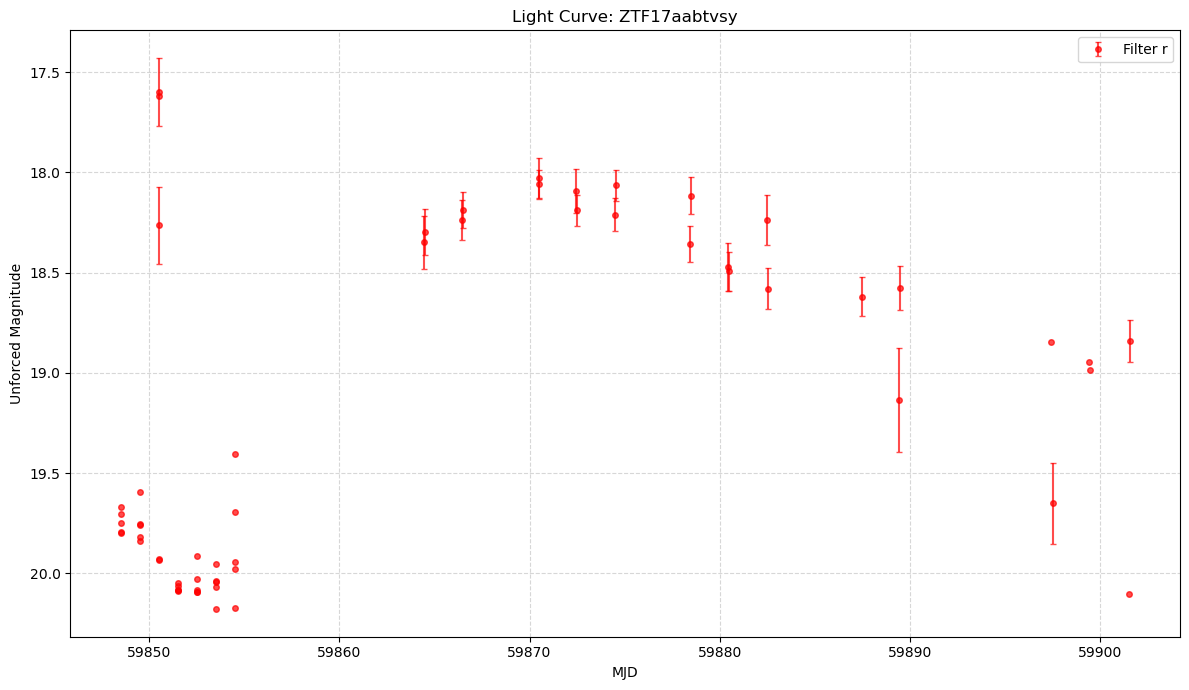

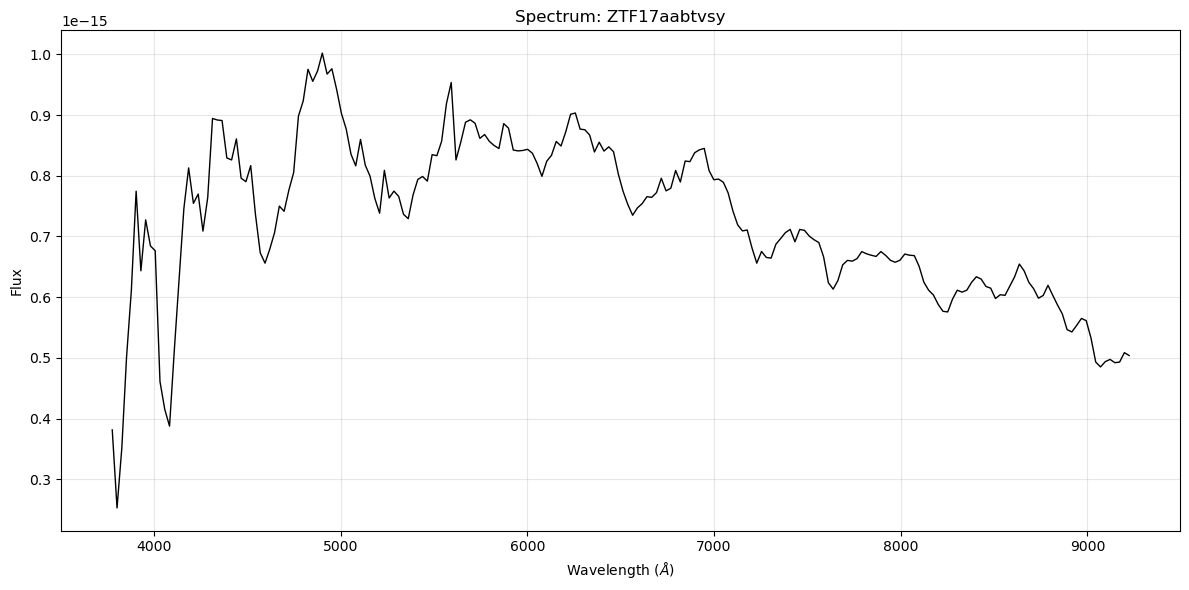

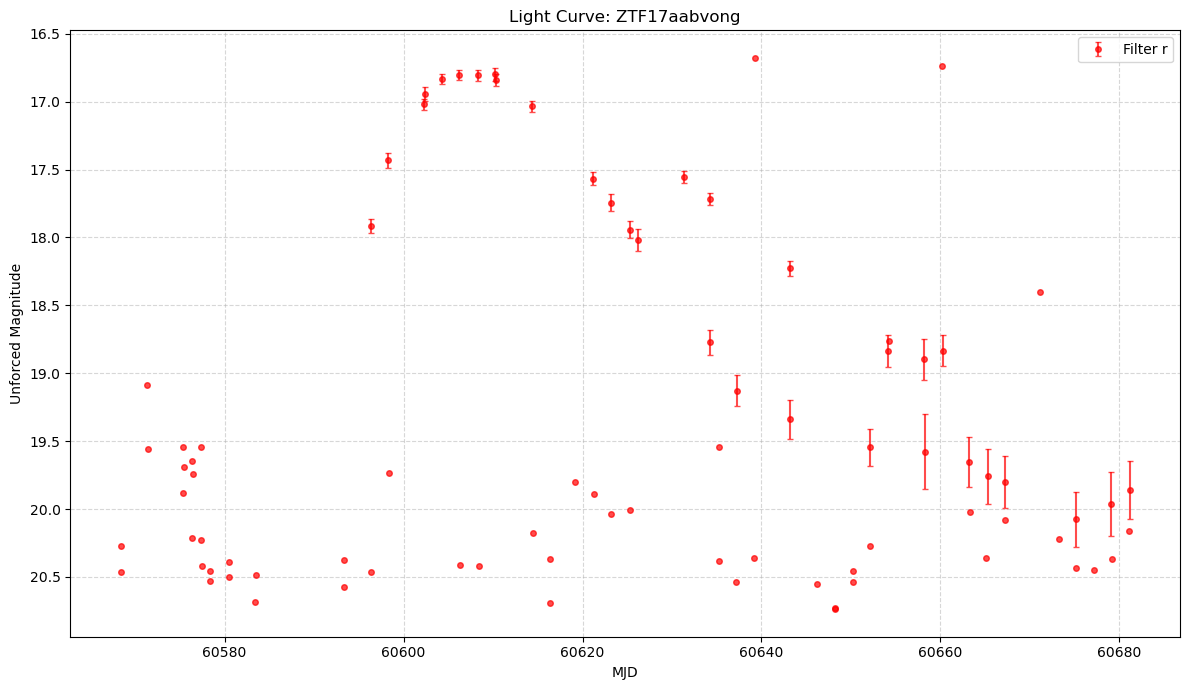

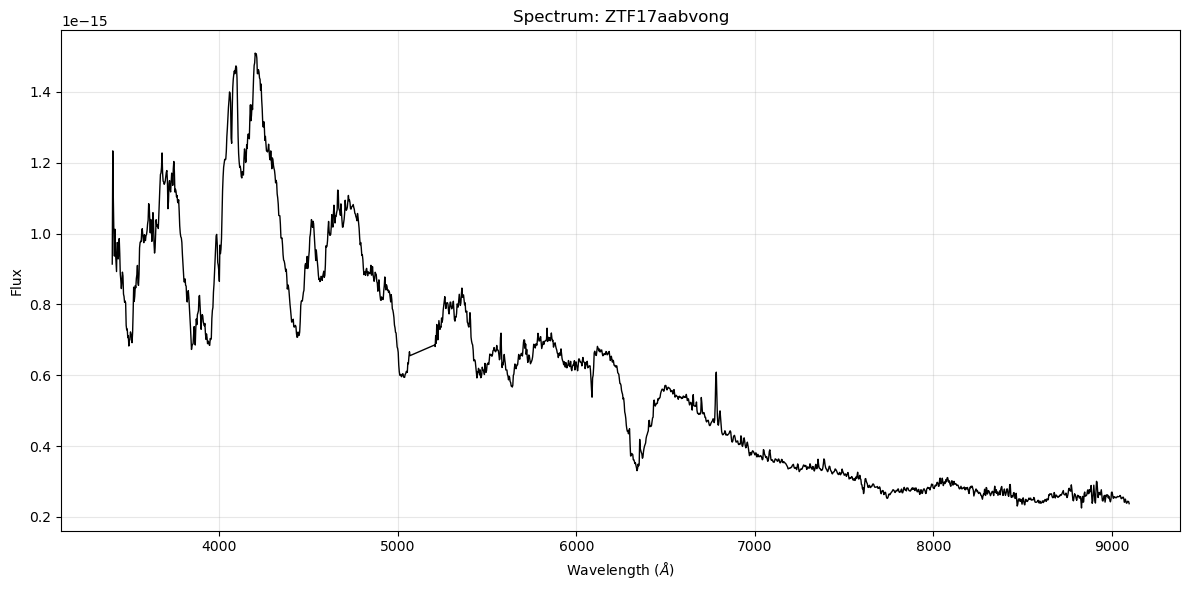

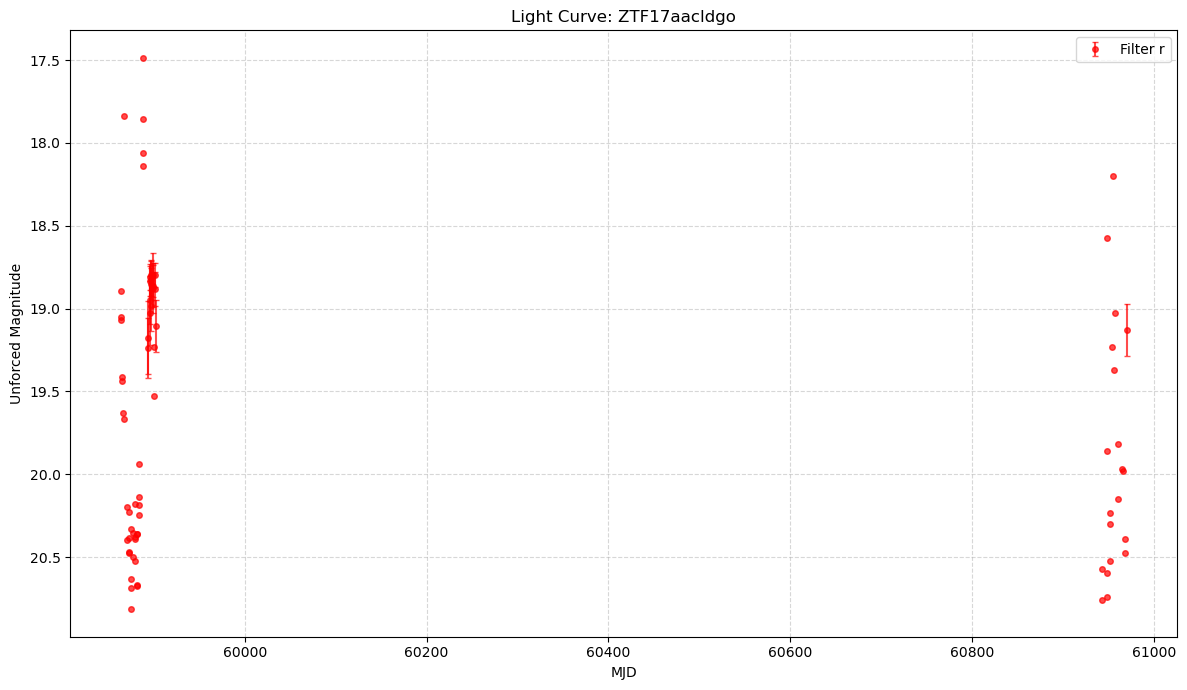

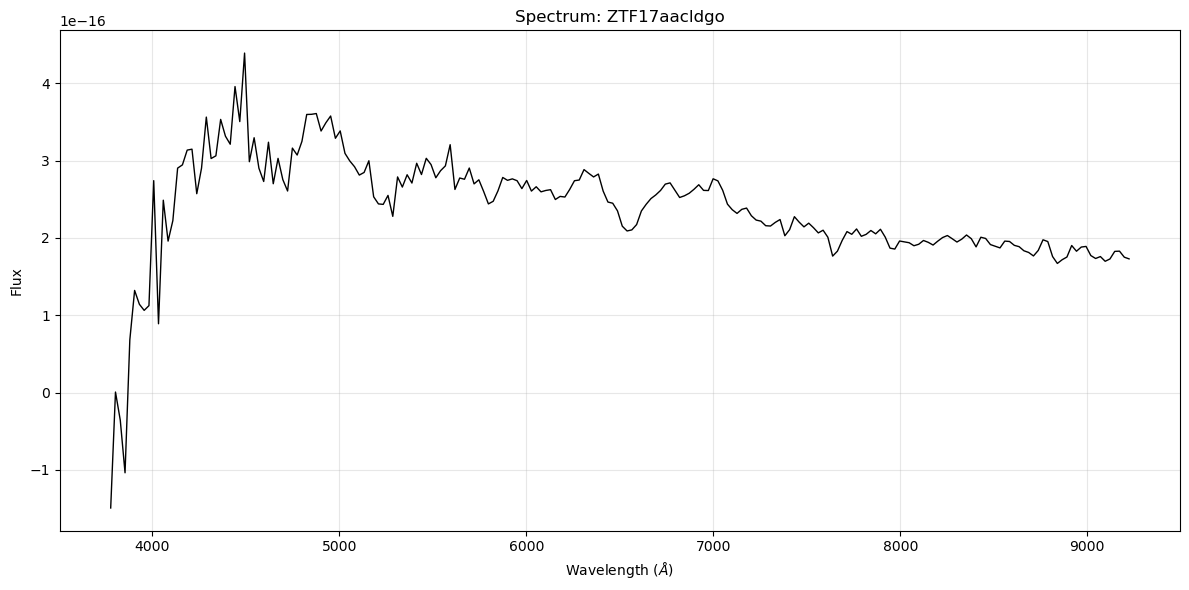

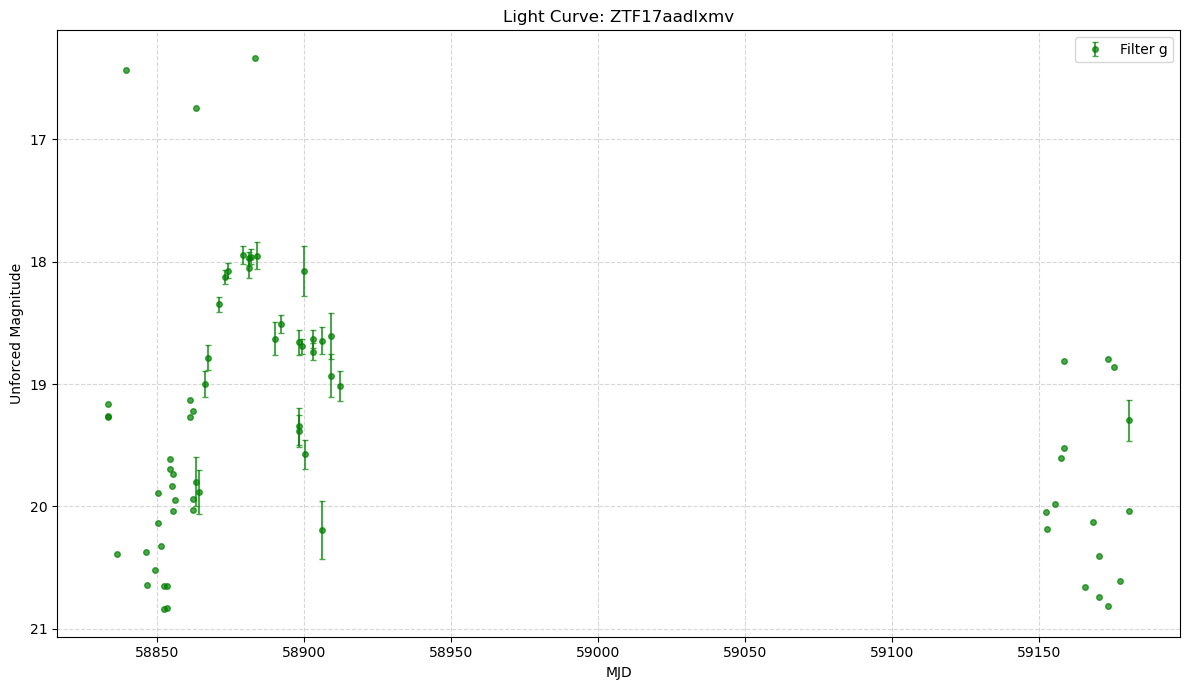

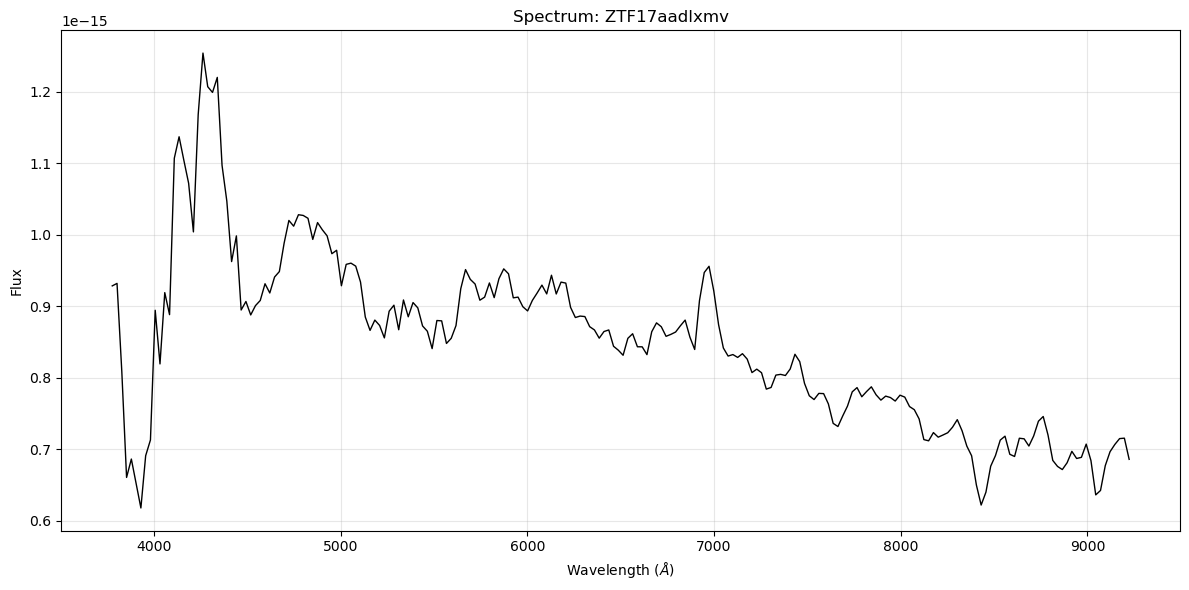

In [16]:
# Plot light curves and spectra (same scope: all or single ID from objects_to_process)
tracker_path = project_root / "data" / run_name / "tracker.csv"
if not objects_to_process.empty and tracker_path.exists():
    tracker_df = pd.read_csv(tracker_path)
    total = len(objects_to_process)
    for idx, (_, obj_row) in enumerate(objects_to_process.iterrows(), 1):
        ztf_id = obj_row['ZTFID']
        row = tracker_df[tracker_df['ztf_id'] == ztf_id]
        lasair_path = (project_root / row.iloc[0]['lasair_path']) if not row.empty and pd.notna(row.iloc[0].get('lasair_path')) and str(row.iloc[0]['lasair_path']).strip() else None
        tns_path = (project_root / row.iloc[0]['tns_path']) if not row.empty and pd.notna(row.iloc[0].get('tns_path')) and str(row.iloc[0]['tns_path']).strip() else None
        if lasair_path is not None and not lasair_path.exists():
            lasair_path = None
        if tns_path is not None and not tns_path.exists():
            tns_path = None
        if lasair_path is None and tns_path is None:
            print(f"[{idx}/{total}] {ztf_id}: Skipping (no data in tracker)")
            continue
        try:
            run_dir = project_root / "runs" / run_name / ztf_id
            lc_path = plot_light_curve_from_lasair(ztf_id, lasair_path, run_dir) if lasair_path else None
            spec_path = plot_spectrum_from_tns(ztf_id, tns_path, run_dir) if tns_path else None
            if lc_path:
                print(f"[{idx}/{total}] {ztf_id}: Light curve → {lc_path}")
            if spec_path:
                print(f"[{idx}/{total}] {ztf_id}: Spectrum → {spec_path}")
        except Exception as e:
            print(f"[{idx}/{total}] {ztf_id}: Plotting failed - {str(e)}")
    print(f"\nPlotting complete for {total} object(s)")
else:
    if objects_to_process.empty:
        print("\nNo objects to plot. Enter a ZTF ID or 'all' and run the download cell first.")
    else:
        print("\nNo tracker found. Run the download cell first.")

In [11]:
# Format selected objects_to_process for sncosmo and save as ztf_cosmo.csv

from utils import process_sncosmo

# Construct DataFrame from currently processed objects
if objects_to_process.empty:
    print("✗ No objects to process for sncosmo export.")
else:
    cosmo_df = pd.DataFrame(objects_to_process)

    # Rename columns to match sncosmo expectations
    col_map = {
        "ZTFID": "ztf_id",
        "IAUID": "iauid",
        "RA": "ra",
        "Dec": "dec",
        "type": "type",
        "redshift": "redshift",
        "peakt": "peak_time",
        "peakmag": "peak_mag",
        "peakabs": "peak_abs",
        "peakfilt": "filter",
        "A_V": "av",
    }

    rename_columns = {orig: new for orig, new in col_map.items() if orig in cosmo_df.columns}
    cosmo_df = cosmo_df.rename(columns=rename_columns)

    cosmo_path = project_root / "data" / "ztf_cosmo.csv"
    cosmo_df.to_csv(cosmo_path, index=False)
    print(f"Saved sncosmo-formatted catalog to {cosmo_path}")

    # Process with sncosmo and save FITS file
    fits_path = process_sncosmo(cosmo_df, source='salt2', project_root=project_root, run_name=run_name)
    print(f"Sncosmo processing complete. FITS file saved to: {fits_path}")

Saved sncosmo-formatted catalog to /Users/david/Code/msc/project/data/ztf_cosmo.csv
✓ Fitted ZTF17aacldgo: t0=0.07, x1=0.00, c=-7.149
Saved 1 sncosmo fit results to runs/{ztf_id}/sncosmo/
Sncosmo processing complete. FITS file saved to: /Users/david/Code/msc/project/runs/ZTF17aacldgo/sncosmo/2026-01-25_sncosmo_models.fits
